In [5]:
import numpy as np
import scipy.io as sp
from scipy.stats import norm
import matplotlib.pyplot as plt    

In [13]:
file_to_open =f'./data/paleo2021_data1.mat'
flora_interpstack = sp.loadmat(file_to_open)
flora_lat = flora_interpstack['lat']
flora_lon = flora_interpstack['lon']
flora_times = flora_interpstack['time_data'].reshape(flora_interpstack['time_data'].shape[1],)
flora_co2_data = flora_interpstack['CO2_data'].reshape(flora_interpstack['CO2_data'].shape[1],)
flora_land_data = flora_interpstack['land_data'].astype(float)
flora_temp_data = flora_interpstack['temp_data'].astype(float)
flora_runoff_data = flora_interpstack['runoff_data'].astype(float)

In [171]:
#CO2 and O2 levels
# these indices are from matlab, not python
co2_level_matlab = np.asarray([21, 19, 19, 18, 17, 16, 15, 12, 11, 12, 12, 14, 16, 16, 16, 13, 14, 11, 12, 11, 9, 8])
# minus 1 for python
co2_level_python = co2_level_matlab - 1
co2_m_stdev = np.asarray([20, 18, 18, 17, 16, 12, 10, 6, 3, 8, 7, 10, 11, 12, 11, 10, 10, 4, 10, 6, 4, 4])
co2_p_stdev = np.asarray([22, 20, 20, 19, 18, 19, 17, 14, 13, 14, 14, 16, 18, 18, 17, 16, 17, 14, 14, 13, 11, 11]) 
o2 = np.asarray([ 1.9, 5.14, 3.74, 5.05, 14.94, 16.76, 16.22, 24.76, 25.52, 27.25, 31.05, 30.77, 32.38, 28.6, 25.13, 25.86, 26.65, 27.69, 25.12, 21.41, 21.57, 20.72])

# Number of loops #
nsteps = 200
# Longitude and latitude #
x_lon = 48
y_lat = 40

# timesteps in 1 year
timestep = 1

# Reservoirs
C_leaf_tem = np.full((y_lat, x_lon, nsteps+1), np.nan)
C_leaf_bor = np.full((y_lat, x_lon, nsteps+1), np.nan)
C_leaf_tro = np.full((y_lat, x_lon, nsteps+1), np.nan)
R_leaf_tem = np.full((y_lat, x_lon, nsteps), np.nan)
R_leaf_bor = np.full((y_lat, x_lon, nsteps), np.nan)
R_leaf_tro = np.full((y_lat, x_lon, nsteps), np.nan)
NPP_tem = np.full((y_lat, x_lon, nsteps), np.nan)
NPP_bor = np.full((y_lat, x_lon, nsteps), np.nan)
NPP_tro = np.full((y_lat, x_lon, nsteps), np.nan)
biomass_tem = np.full((y_lat, x_lon, nsteps+1), np.nan)
biomass_bor = np.full((y_lat, x_lon, nsteps+1), np.nan)
biomass_tro = np.full((y_lat, x_lon, nsteps+1), np.nan)

# final outputs
final_biomass_tem = np.full((y_lat, x_lon, len(flora_times)), np.nan)
final_biomass_bor = np.full((y_lat, x_lon, len(flora_times)), np.nan)
final_biomass_tro = np.full((y_lat, x_lon, len(flora_times)), np.nan)
final_NPP_tem = np.full((y_lat, x_lon, len(flora_times)), np.nan)
final_NPP_bor = np.full((y_lat, x_lon, len(flora_times)), np.nan)
final_NPP_tro = np.full((y_lat, x_lon, len(flora_times)), np.nan)
temp_end = np.full((y_lat, x_lon, len(flora_times)), np.nan)
runoff_end = np.full((y_lat, x_lon, len(flora_times)), np.nan)

### some parameters ###
# Q10 temperature dependence
t25 = 2600
q_10t = 0.57

# Intracellular partial pressure 
v = 0.7
kc25 = 30
ko25 = 3e4
q_10c = 2.1
q_10o = 1.2
s = 0.015
alpha = 0.08
theta = 0.7
lr_max = 0.75

# Leaf c:n ratio
CN_leaf = 29

# Tissue respiration rate at 10 degree C
r_tem = 0.055 * 365 # 0.066 for some PFTs; gC/gN/d -> gC/gN/year
r_bor = 0.066 * 365
r_tro = 0.011 * 365

# Growth respiraition
R_growth = 0.25

# Leaf longevity; ranges from 0.5 - 1 depending on type of plant
life_leaf_tem = 0.75 
life_leaf_bor = 0.75
life_leaf_tro = 1

ins_present = 150 + 250 * np.outer(norm.pdf(flora_lat, 0, 40) / norm.pdf(0, 0, 40), np.ones(x_lon))
# plot?
#plt.imshow(ins_present)

In [172]:
for flora_time_ind, flora_time in enumerate(flora_times):
    print(flora_time_ind, flora_time)

    # we will count forward in time based on our climate data
    # get index of co2
    co2_ind = co2_level[flora_time_ind]
    co2_ppm = flora_co2_data[co2_ind] # ppm = micromol

    # land
    land = flora_land_data[:, :, flora_time_ind]
    land[land == 0] = np.nan

    # temperature, masked by land
    temp = flora_temp_data[:,:, co2_ind, flora_time_ind] * land

    # runoff, masked by land
    runoff = flora_runoff_data[:,:, co2_ind, flora_time_ind] * land

    # mask out where ice forms?
    temp[temp < -10] = np.nan
    

    #Ambient partial pressure
    po2 = o2[flora_time_ind] * 1000
    pco2 = co2_ppm

    tf = t25*(q_10t**((temp - 25)*0.1))
    tstar = po2/(2*tf )
    pi = v * pco2
    kc = kc25*(q_10c**((temp - 25)*0.1))
    ko = ko25*(q_10o**((temp - 25)*0.1))
    c2 = (pi - tstar)/(pi + kc*(1 + (po2/ko)))

    # make ftemps for temperate, boreal and tropical regions
    ftemp_tem = norm.pdf(temp, loc=15, scale=20)
    ftemp_bor = norm.pdf(temp, loc=0, scale=20)
    ftemp_tro = norm.pdf(temp, loc=27, scale=7)
    c1_bor = alpha*ftemp_bor**((pi - tstar)/(pi + 2*tstar)) 
    c1_tem = alpha*ftemp_tem**((pi - tstar)/(pi + 2*tstar)) 
    c1_tro = alpha*ftemp_tro**((pi - tstar)/(pi + 2*tstar))

    sigma = (1 - ((c2 - s)/(c2 - theta*s)))**0.5

    #Change in insolation overtime
    ins = ins_present - (ins_present*4.6/100*(abs(flora_times[flora_time_ind])/570))
    
    # Maintenance respiration # 
    # Arrhenius equation; temperature function for respiration
    g_T = np.exp(308.56*((1/56.02) - (1/(temp + 46.02))))

    ### Water presence ###

    # converting actual runoff into a sigmoidal curve; water presence ranked
    # from 0-1
    # test_water = runoff_re ; 
    # test_water(test_water == 0 | isnan(test_water)) = NaN ; 
    # test_water = circshift( test_water, -6 ) ; 
    water_stress = 1 - (1/(1 + np.exp(0.005*(runoff - 450))))

    ### PHOTOSYNTHESIS in gC/ m^2/ year ###
    photosynth_tem = 10*365*ins*(c1_tem/c2)*(c2 - (2*theta - 1)*s - 2*(c2 - theta*s)*sigma)*water_stress
    photosynth_bor = 10*365*ins*(c1_bor/c2)*(c2 - (2*theta - 1)*s - 2*(c2 - theta*s)*sigma)*water_stress
    photosynth_tro = 10*365*ins*(c1_tro/c2)*(c2 - (2*theta - 1)*s - 2*(c2 - theta*s)*sigma)*water_stress

    ### CARBON IN LEAF ###
    # 0 for initial state
    C_leaf_tem[:,:,0] = lr_max*photosynth_tem
    C_leaf_bor[:,:,0] = lr_max*photosynth_bor
    C_leaf_tro[:,:,0] = lr_max*photosynth_tro
    # gC/ m^2/ year

    ### BIOMASS ###
    biomass_tem[:,:,0] = 2.5e4*land
    biomass_tem[biomass_tem == 0] = np.nan

    biomass_bor[:,:,0] = 2.5e4*land
    biomass_bor[biomass_bor == 0] = np.nan
    biomass_tro[:,:,0] = 2.5e4*land
    biomass_tro[biomass_tro == 0] = np.nan
    # gC/m^2/year    
    
    for biomass_ind, biomass_step in enumerate(np.arange(nsteps)):

        ### Leaf respiration ###
        R_leaf_bor[:,:,biomass_ind] = r_bor*(C_leaf_bor[:,:,biomass_ind]/CN_leaf)*g_T
        R_leaf_bor[R_leaf_bor < 0] = 0
        R_leaf_tem[:,:,biomass_ind] = r_tem*(C_leaf_tem[:,:,biomass_ind]/CN_leaf )*g_T
        R_leaf_tem[R_leaf_tem < 0] = 0 
        R_leaf_tro[:,:,biomass_ind] = r_tro * ( C_leaf_tro[:,:,biomass_ind]/CN_leaf)*g_T
        R_leaf_tro[R_leaf_tro < 0] = 0


        ### NPP in gC/m2/year ###
        NPP_bor[:,:,biomass_ind] = (1 - R_growth)*(photosynth_bor - R_leaf_bor[:,:,biomass_ind])
        NPP_tem[:,:,biomass_ind] = (1 - R_growth)*(photosynth_tem - R_leaf_tem[:,:,biomass_ind])
        NPP_tro[:,:,biomass_ind] = (1 - R_growth)*(photosynth_tro - R_leaf_tro[:,:,biomass_ind])

        ### Carbon in leaf allocation ###
        C_leaf_bor[:,:,biomass_ind+1] = (C_leaf_bor[:,:,biomass_ind]*(1 - life_leaf_bor)) + (lr_max*NPP_bor[:,:,biomass_ind])
        C_leaf_tem[:,:,biomass_ind+1] = (C_leaf_tem[:,:,biomass_ind]*(1 - life_leaf_tem)) + (lr_max*NPP_tem[:,:,biomass_ind])
        C_leaf_tro[:,:,biomass_ind+1] = (C_leaf_tro[:,:,biomass_ind]*(1 - life_leaf_tro)) + (lr_max*NPP_tro[:,:,biomass_ind])

        ### Biomass ###
        biomass_bor[:,:,biomass_ind+1] = biomass_bor[:,:,biomass_ind] + (C_leaf_bor[:,:,biomass_ind] - 0.1*biomass_bor[:,:,biomass_ind])*timestep
        biomass_tem[:,:,biomass_ind+1] = biomass_tem[:,:,biomass_ind] + (C_leaf_tem[:,:,biomass_ind] - 0.1*biomass_tem[:,:,biomass_ind])*timestep 
        biomass_tro[:,:,biomass_ind+1] = biomass_tro[:,:,biomass_ind] + (C_leaf_tro[:,:,biomass_ind] - 0.1*biomass_tro[:,:,biomass_ind])*timestep 

    final_biomass_tem[:,:,flora_time_ind] = biomass_tem[:,:,-1]
    final_biomass_bor[:,:,flora_time_ind] = biomass_bor[:,:,-1]
    final_biomass_tro[:,:,flora_time_ind] = biomass_tro[:,:,-1]
    
    final_NPP_tem[:,:,flora_time_ind] = NPP_tem[:,:,-1]
    final_NPP_bor[:,:,flora_time_ind] = NPP_bor[:,:,-1]
    final_NPP_tro[:,:,flora_time_ind] = NPP_tro[:,:,-1]
    
    #Saving temp info 
    temp_end[:,:,flora_time_ind] = temp
    runoff_end[:,:,flora_time_ind] = runoff

0 -540.0
1 -500.0
2 -470.0
3 -450.0
4 -430.0
5 -400.0
6 -370.0
7 -340.0
8 -300.0
9 -280.0
10 -260.0
11 -245.0
12 -220.0
13 -200.0
14 -180.0
15 -145.0
16 -90.0
17 -70.0
18 -52.0
19 -30.0
20 -15.0
21 -0.0


In [187]:
NPP_bor.shape

(40, 48, 200)

In [177]:
import numpy as np

# Assuming all final_biomass_* arrays are numpy arrays with shape (x_lon, y_lat, len(flora_times))
final_biomass = np.empty_like(final_biomass_tem)
biome = np.empty_like(final_biomass_tem, dtype=int)
final_NPP = np.empty_like(final_biomass_tem, dtype=float)

for flora_time_ind, flora_time in enumerate(flora_times):
    for lon_ind in range(x_lon):
        for lat_ind in range(y_lat):
            # Maximum biomass among the three types
            final_biomass[lat_ind, lon_ind, flora_time_ind] = max(
                final_biomass_tem[lat_ind, lon_ind, flora_time_ind],
                final_biomass_bor[lat_ind, lon_ind, flora_time_ind],
                final_biomass_tro[lat_ind, lon_ind, flora_time_ind]
            )


            # Assign biome and NPP based on which biomass is max
            if final_biomass[lat_ind, lon_ind, flora_time_ind] == final_biomass_tem[lat_ind, lon_ind, flora_time_ind]:
                biome[lat_ind, lon_ind, flora_time_ind] = 1
                final_NPP[i, lon_ind, flora_time_ind] = final_NPP_tem[lat_ind, lon_ind, flora_time_ind]
            elif final_biomass[lat_ind, lon_ind, flora_time_ind] == final_biomass_bor[lat_ind, lon_ind, flora_time_ind]:
                biome[lat_ind, lon_ind, flora_time_ind] = 2
                final_NPP[lat_ind, lon_ind, flora_time_ind] = final_NPP_bor[lat_ind, lon_ind, flora_time_ind]
            elif final_biomass[lat_ind, lon_ind, flora_time_ind] == final_biomass_tro[lat_ind, lon_ind, flora_time_ind]:
                biome[lat_ind, lon_ind, flora_time_ind] = 3
                final_NPP[lat_ind, lon_ind, flora_time_ind] = final_NPP_tro[lat_ind, lon_ind, flora_time_ind]
            else:
                biome[lat_ind, lon_ind, flora_time_ind] = 4
                final_NPP[lat_ind, lon_ind, flora_time_ind] = np.nan

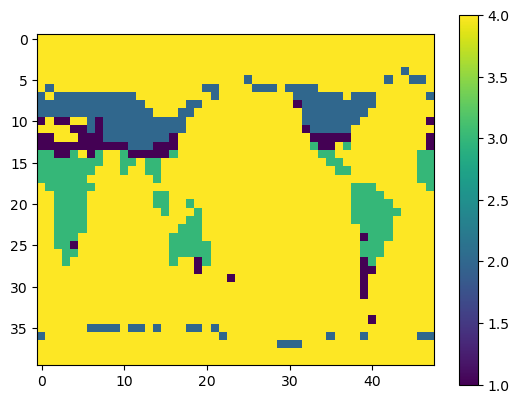

In [188]:
plt.imshow(biome[:,:,-1])
plt.colorbar()

In [95]:
np.nansum(R_leaf_tem[:,:,0])

np.float64(145627.78703505915)

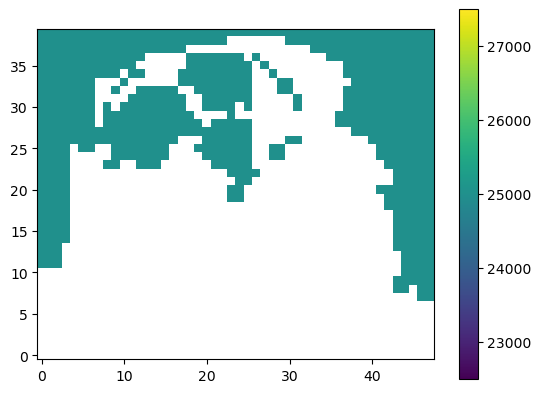

In [83]:
plt.imshow(biomass_tro[:,:,0], origin='lower')
plt.colorbar()

In [11]:
flora_land

NameError: name 'flora_land' is not defined